**Base Titanic **

In [22]:
!pip -q install yellowbrick
!pip install treeinterpreter
!pip install scikit-optimize

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from sklearn.preprocessing import LabelEncoder

In [24]:
import pickle
with open('/content/sample_data/titanic.pkl', 'rb') as f:
  X_treino, X_teste, y_treino, y_teste = pickle.load(f)

In [25]:
X_treino

,Pclass,Sex,Age,SibSp,Parch
331,1,1,1,0,0
733,2,1,4,0,0
382,3,1,1,0,0
704,3,1,4,1,0
813,3,0,2,4,2
...,...,...,...,...,...
106,3,0,4,0,0
270,1,1,4,0,0
860,3,1,1,2,0
435,1,0,0,1,2


In [27]:
modelo = RandomForestClassifier(random_state = 42)

# Encode target variable
le = LabelEncoder()
y_treino_encoded = le.fit_transform(y_treino)
y_teste_encoded = le.transform(y_teste)

# Espaço de busca (hiperparâmetros de teste)
param_grid = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': (2, 20),          # de 2 até 20
    'max_features': (1, 20),   # de 1 até 20
}

# Otimização Bayesiana
opt = BayesSearchCV(
    modelo,
    param_grid,
    n_iter=32,
    cv=3,
    n_jobs=-1,
    random_state=42,
    scoring='f1'
)

# Treinamento
opt.fit(X_treino, y_treino_encoded)

print("Melhor score de validação:", opt.best_score_)
print("Score no teste:", opt.score(X_teste, y_teste_encoded))
print("Melhores parâmetros:", opt.best_params_)

#modelo.fit(X_treino, y_treino)

Melhor score de validação: 0.7502472668574364
Score no teste: 0.7482014388489209
Melhores parâmetros: OrderedDict({'criterion': 'entropy', 'max_features': 20, 'n_estimators': 6})


In [33]:
modelo = RandomForestClassifier(
    criterion='entropy',
    max_features=20,
    n_estimators=6,
    random_state=42           # Garante que o resultado seja o mesmo toda vez
)

# treinamento com o novo modelo
modelo.fit(X_treino, y_treino)

RandomForestClassifier(criterion='entropy', max_features=20, n_estimators=6,
                       random_state=42)



> **Vamos testar o modelo?**



In [34]:
previsoes = modelo.predict(X_teste)

In [35]:
previsoes

array(['nao morreu', 'morreu', 'morreu', 'nao morreu', 'morreu',
       'nao morreu', 'nao morreu', 'morreu', 'nao morreu', 'morreu',
       'morreu', 'morreu', 'morreu', 'morreu', 'morreu', 'nao morreu',
       'morreu', 'nao morreu', 'morreu', 'morreu', 'morreu', 'morreu',
       'nao morreu', 'morreu', 'morreu', 'nao morreu', 'morreu', 'morreu',
       'nao morreu', 'morreu', 'morreu', 'nao morreu', 'morreu',
       'nao morreu', 'morreu', 'morreu', 'morreu', 'nao morreu',
       'nao morreu', 'morreu', 'morreu', 'morreu', 'morreu', 'morreu',
       'nao morreu', 'morreu', 'morreu', 'morreu', 'morreu', 'morreu',
       'nao morreu', 'nao morreu', 'morreu', 'nao morreu', 'morreu',
       'nao morreu', 'morreu', 'nao morreu', 'nao morreu', 'nao morreu',
       'morreu', 'nao morreu', 'nao morreu', 'morreu', 'morreu',
       'nao morreu', 'morreu', 'morreu', 'morreu', 'nao morreu',
       'nao morreu', 'nao morreu', 'morreu', 'nao morreu', 'morreu',
       'morreu', 'morreu', 'morreu',



> **Será se o modelo acertou?**



In [36]:
y_teste

,Survived
709,nao morreu
439,morreu
840,morreu
720,nao morreu
39,nao morreu
...,...
433,morreu
773,morreu
25,nao morreu
84,nao morreu


In [39]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy_score(y_teste,previsoes)

0.8044692737430168

In [40]:
from yellowbrick.classifier import ConfusionMatrix
confusion_matrix(y_teste, previsoes)

array([[92, 13],
       [22, 52]])

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.8044692737430168

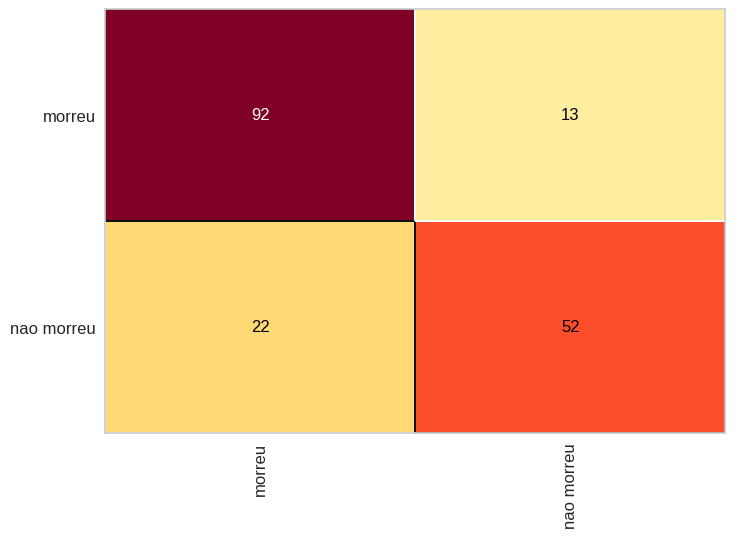

In [41]:
cm = ConfusionMatrix(modelo)
cm.fit(X_treino, y_treino)
cm.score(X_teste, y_teste)

In [42]:
print(classification_report(y_teste, previsoes))

              precision    recall  f1-score   support

      morreu       0.81      0.88      0.84       105
  nao morreu       0.80      0.70      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



**Vamos ver os atributos que o Random considerou como mais importantes?**

Variáveis mais relevantes:
Sex: 0.4356008206334212
Pclass: 0.20195819159783704
Age: 0.13317671112674143
SibSp: 0.12500717203834272
Parch: 0.10425710460365761


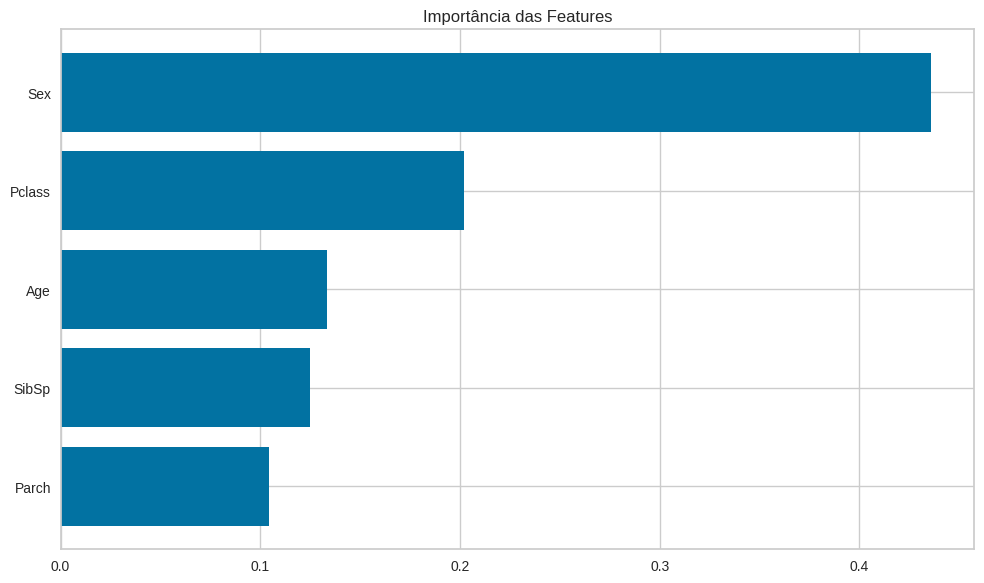

In [43]:
# Obter a importância das features
importancias = modelo.feature_importances_

# Pegando os nomes dos atributos
nomes_das_features = X_treino.columns

# Ordenar as features com base na importância
indices_ordenados = np.argsort(importancias)[::-1]

# Exibir as features mais importantes
print("Variáveis mais relevantes:")
for idx in indices_ordenados:
    print(f"{nomes_das_features[idx]}: {importancias[idx]}")

# Plotar a importância das features
plt.figure(figsize=(10, 6))
plt.title("Importância das Features")
plt.barh(range(X_treino.shape[1]), importancias[indices_ordenados], align="center")
plt.yticks(range(X_treino.shape[1]), nomes_das_features[indices_ordenados])
plt.gca().invert_yaxis()  # Inverter o eixo y para que as features mais importantes fiquem no topo
plt.tight_layout()
plt.show()